In [1]:
import ray
import cProfile
import pstats
import time
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ray.init()

Waiting for redis server at 127.0.0.1:35596 to respond...
Waiting for redis server at 127.0.0.1:63023 to respond...
Starting local scheduler with the following resources: {'CPU': 8, 'GPU': 0}.

View the web UI at http://localhost:8890/notebooks/ray_ui67392.ipynb?token=4e0630d80139d13f8ed6e56564b320ee4f3a1bf8c6208edd



{'local_scheduler_socket_names': ['/tmp/scheduler19777857'],
 'node_ip_address': '127.0.0.1',
 'object_store_addresses': [ObjectStoreAddress(name='/tmp/plasma_store52747897', manager_name='/tmp/plasma_manager16294683', manager_port=50024)],
 'redis_address': '127.0.0.1:35596',
 'webui_url': 'http://localhost:8890/notebooks/ray_ui67392.ipynb?token=4e0630d80139d13f8ed6e56564b320ee4f3a1bf8c6208edd'}

# Functions

In [3]:
def get_profile_data(arr):
    pr = cProfile.Profile(timeunit = .000001)
    pr.enable()
    ray.put(arr)
    pr.disable()
    return pr

In [4]:
def stats_printer(profile_object):
    s = StringIO.StringIO()
    sortby = 'module'
    ps = pstats.Stats(profile_object, stream=s).sort_stats(sortby)
    ps.strip_dirs()
    ps.print_stats('worker|plasma')
    print(s.getvalue())

In [5]:
def print_profile_data(arr, return_put = False):
    profile_data = get_profile_data(arr)
    put = 0.0
    
    print('ncalls', 'tottime', 'inlinetime', 'filename(function)', sep='\t\t')
    for line in profile_data.getstats():
        code = line.code
        if type(code) is not str:
            code = code.co_filename.split('/')[-1]+":"+code.co_name

        ncalls = line.callcount
        tottime = "%.6f" % line.totaltime
        inlinetime = "%.6f" % line.inlinetime

        if code == "<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>":
            put = tottime
        
        print(ncalls, tottime, inlinetime, code, sep='\t\t')
        
        if return_put:
            return put

In [6]:
def get_put_time(arr):
    profile_data = get_profile_data(arr)
    put = 0.0
    
    for line in profile_data.getstats():
        code = line.code
        if type(code) is not str:
            code = code.co_filename.split('/')[-1]+":"+code.co_name
            
        if code == "<method 'put' of 'pyarrow.plasma.PlasmaClient' objects>":
            put = line.totaltime

    return put

# Test Inputs

In [7]:
short_numpy_array = np.array([1,2,3,4,5])
large_numpy_array = np.array([i for i in range(100000)])
very_large_numpy_array = np.array([i for i in range(1000000)])

In [8]:
sys.getsizeof(short_numpy_array)

136

In [9]:
sys.getsizeof(large_numpy_array)

800096

In [10]:
sys.getsizeof(very_large_numpy_array)

8000096

# Profiling Results with Custom Printer

In [11]:
print_profile_data(short_numpy_array)

ncalls		tottime		inlinetime		filename(function)
2		0.000000		0.000000		<method 'items' of 'dict' objects>
4		0.000003		0.000003		<built-in method builtins.isinstance>
1		0.000000		0.000000		<built-in method _thread.get_ident>
1		0.000001		0.000001		threading.py:name
1		0.000003		0.000002		threading.py:getName
1		0.000004		0.000004		threading.py:current_thread
1		0.000000		0.000000		<method 'disable' of '_lsprof.Profiler' objects>
1		0.001540		0.000034		worker.py:store_and_register
1		0.000027		0.000027		<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1		0.000001		0.000001		<method 'id' of 'common.ObjectID' objects>
1		0.001557		0.000014		worker.py:put_object
1		0.000011		0.000004		worker.py:check_main_thread
1		0.000002		0.000002		worker.py:check_connected
1		0.000003		0.000003		worker.py:__init__
1		0.000015		0.000005		worker.py:__enter__
1		0.000009		0.000004		worker.py:__exit__
1		0.000007		0.000004		worker.py:log_span
2		0.000001		0.000001		worker.py:<di

In [12]:
print_profile_data(large_numpy_array)

ncalls		tottime		inlinetime		filename(function)
2		0.000001		0.000001		<method 'items' of 'dict' objects>
4		0.000002		0.000002		<built-in method builtins.isinstance>
1		0.000001		0.000001		<built-in method _thread.get_ident>
1		0.000001		0.000001		threading.py:name
1		0.000003		0.000002		threading.py:getName
1		0.000003		0.000002		threading.py:current_thread
1		0.000000		0.000000		<method 'disable' of '_lsprof.Profiler' objects>
1		0.008625		0.000015		worker.py:store_and_register
1		0.000025		0.000025		<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1		0.000001		0.000001		<method 'id' of 'common.ObjectID' objects>
1		0.008631		0.000004		worker.py:put_object
1		0.000010		0.000004		worker.py:check_main_thread
1		0.000001		0.000001		worker.py:check_connected
1		0.000001		0.000001		worker.py:__init__
1		0.000012		0.000002		worker.py:__enter__
1		0.000010		0.000003		worker.py:__exit__
1		0.000005		0.000004		worker.py:log_span
2		0.000001		0.000001		worker.py:<di

In [13]:
print_profile_data(very_large_numpy_array)

ncalls		tottime		inlinetime		filename(function)
2		0.000000		0.000000		<method 'items' of 'dict' objects>
4		0.000003		0.000003		<built-in method builtins.isinstance>
1		0.000001		0.000001		<built-in method _thread.get_ident>
1		0.000003		0.000003		threading.py:name
1		0.000004		0.000001		threading.py:getName
1		0.000006		0.000005		threading.py:current_thread
1		0.000000		0.000000		<method 'disable' of '_lsprof.Profiler' objects>
1		0.213542		0.000036		worker.py:store_and_register
1		0.000051		0.000051		<method 'compute_put_id' of 'local_scheduler.LocalSchedulerClient' objects>
1		0.000002		0.000002		<method 'id' of 'common.ObjectID' objects>
1		0.213554		0.000010		worker.py:put_object
1		0.000015		0.000005		worker.py:check_main_thread
1		0.000002		0.000002		worker.py:check_connected
1		0.000002		0.000002		worker.py:__init__
1		0.000018		0.000004		worker.py:__enter__
1		0.000015		0.000005		worker.py:__exit__
1		0.000007		0.000005		worker.py:log_span
2		0.000001		0.000001		worker.py:<di

[1, 10, 100, 1000, 10000, 100000, 1000000, 10000000]
[0.00021559999999999998, 0.00016539999999999998, 0.00021880000000000003, 0.00020879999999999995, 0.0003789, 0.0011403, 0.008023899999999999, 0.053356]


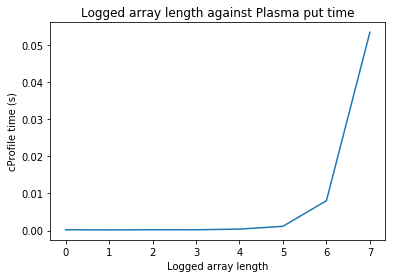

In [14]:
xs = [10**i for i in range(8)]
ys = []
for x in xs:
    samples = []
    for j in range(10):
        samples.append(get_put_time(np.array([i for i in range(x)])))
    ys.append(np.average(samples))
    
print(xs)
print(ys)

plt.title('Logged array length against Plasma put time')
plt.xlabel('Logged array length')
plt.ylabel('cProfile time (s)')
plt.plot(np.log10(xs), ys)

# Profiling Results with Default Printer

In [ ]:
get_profile_data(short_numpy_array).print_stats()

In [ ]:
get_profile_data(large_numpy_array).print_stats()

In [ ]:
get_profile_data(very_large_numpy_array).print_stats()